In [1]:
import chess
import chess.pgn
import random
import math
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from IPython.display import display, SVG



In [3]:
class MCTSNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visit_count = 0
        self.value = 0

def uct(node):
    return node.value / (node.visit_count + 1) + math.sqrt(2 * math.log(node.parent.visit_count + 1) / (node.visit_count + 1))

def select_best_child(node):
    return max(node.children, key=uct)

def simulate(state):
    board = chess.Board(state.fen())
    while not board.is_game_over():
        move = random.choice(list(board.legal_moves))
        board.push(move)
    return 1 if board.result() == "1-0" else 0 if board.result() == "1/2-1/2" else -1

def backpropagate(node, result):
    while node is not None:
        node.visit_count += 1
        node.value += result
        node = node.parent
        result = -result

def expand(node):
    for move in node.state.legal_moves:
        new_state = node.state.copy()
        new_state.push(move)
        child_node = MCTSNode(new_state, parent=node)
        node.children.append(child_node)


In [4]:
def mcts(root, iterations):
    for _ in range(iterations):
        node = root
        while node.children:
            node = select_best_child(node)
        if node.visit_count == 0:
            result = simulate(node.state)
            backpropagate(node, result)
        else:
            expand(node)

def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return heuristic_evaluation(board)
    if maximizing_player:
        max_eval = -math.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = math.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def greedy_move(board):
    best_move = None
    best_value = -math.inf
    for move in board.legal_moves:
        board.push(move)
        value = sum(piece.piece_type for piece in board.piece_map().values())
        if value > best_value:
            best_value = value
            best_move = move
        board.pop()
    return best_move

def piece_development_move(board):
    development_pieces = [chess.KNIGHT, chess.BISHOP]
    best_move = None
    for move in board.legal_moves:
        board.push(move)
        if board.piece_type_at(move.to_square) in development_pieces:
            best_move = move
            board.pop()
            break
        board.pop()
    if best_move is None:
        best_move = random.choice(list(board.legal_moves))
    return best_move

def castling_move(board):
    castling_moves = [move for move in board.legal_moves if board.is_castling(move)]
    if castling_moves:
        return random.choice(castling_moves)
    return random.choice(list(board.legal_moves))

def is_isolated_pawn(board, square):
    file = chess.square_file(square)
    for adj_file in [file - 1, file + 1]:
        if adj_file >= 0 and adj_file <= 7:
            for rank in range(8):
                if board.piece_type_at(chess.square(adj_file, rank)) == chess.PAWN:
                    return False
    return True

def pawn_structure_move(board):
    best_move = None
    best_value = -math.inf
    for move in board.legal_moves:
        board.push(move)
        value = sum(1 for square in chess.SQUARES if board.piece_type_at(square) == chess.PAWN and not is_isolated_pawn(board, square))
        if value > best_value:
            best_value = value
            best_move = move
        board.pop()
    if best_move is None:
        best_move = random.choice(list(board.legal_moves))
    return best_move

def heuristic_evaluation(board):
    piece_values = {
        chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
        chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0
    }
    eval = 0
    for piece in board.piece_map().values():
        eval += piece_values[piece.piece_type] * (1 if piece.color == chess.WHITE else -1)
    return eval


In [10]:
def play_game(mcts_iterations, minimax_depth, strategy='minimax'):
    board = chess.Board()
    mcts_times = []
    minimax_times = []
    mcts_eval = []
    minimax_eval = []
    moves = []
    
    while not board.is_game_over():
        # MCTS Move
        root = MCTSNode(board)
        start_time = time.time()
        mcts(root, mcts_iterations)
        mcts_move = select_best_child(root).state.peek()
        mcts_times.append(time.time() - start_time)
        mcts_eval.append(heuristic_evaluation(board))
        board.push(mcts_move)
        moves.append(board.fen())
        if board.is_game_over():
            break

        # Strategy Move
        start_time = time.time()
        if strategy == 'minimax':
            best_move = None
            best_value = -math.inf
            for move in board.legal_moves:
                board.push(move)
                move_value = minimax(board, minimax_depth, -math.inf, math.inf, False)
                board.pop()
                if move_value > best_value:
                    best_value = move_value
                    best_move = move
            minimax_times.append(time.time() - start_time)
            minimax_eval.append(heuristic_evaluation(board))
            board.push(best_move)
        elif strategy == 'random':
            move = random.choice(list(board.legal_moves))
            board.push(move)
            minimax_times.append(time.time() - start_time)
            minimax_eval.append(heuristic_evaluation(board))
        elif strategy == 'greedy':
            move = greedy_move(board)
            board.push(move)
            minimax_times.append(time.time() - start_time)
            minimax_eval.append(heuristic_evaluation(board))
        elif strategy == 'development':
            move = piece_development_move(board)
            board.push(move)
            minimax_times.append(time.time() - start_time)
            minimax_eval.append(heuristic_evaluation(board))
        elif strategy == 'castling':
            move = castling_move(board)
            board.push(move)
            minimax_times.append(time.time() - start_time)
            minimax_eval.append(heuristic_evaluation(board))
        elif strategy == 'pawn_structure':
            move = pawn_structure_move(board)
            board.push(move)
            minimax_times.append(time.time() - start_time)
            minimax_eval.append(heuristic_evaluation(board))
        moves.append(board.fen())
    
    result = board.result()
    return result, mcts_times, minimax_times, moves, mcts_eval, minimax_eval

def visualize_board(fen, title=''):
    board = chess.Board(fen)
    display(SVG(chess.svg.board(board=board)))
    print(title)

def endgame_scenario(board):
    board.set_fen("8/8/8/8/8/8/4K3/k7 w - - 0 1")
    return board


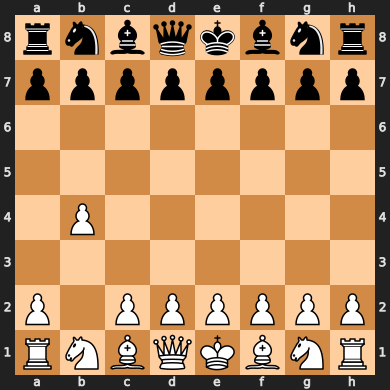

Initial Position: Minimax


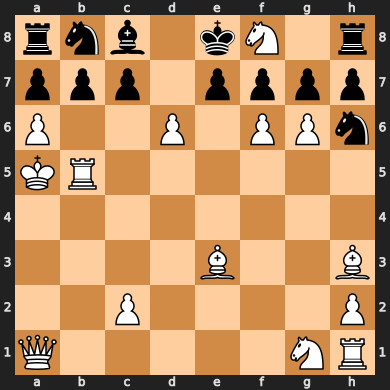

Mid Game: Minimax


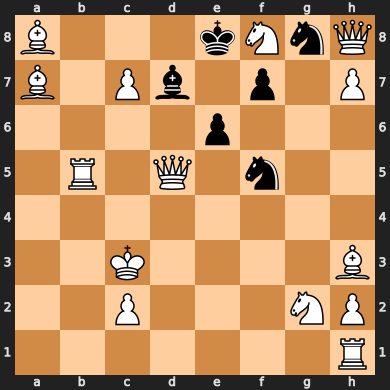

End Game: Minimax


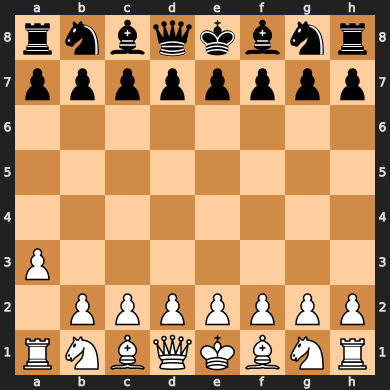

Initial Position: Random


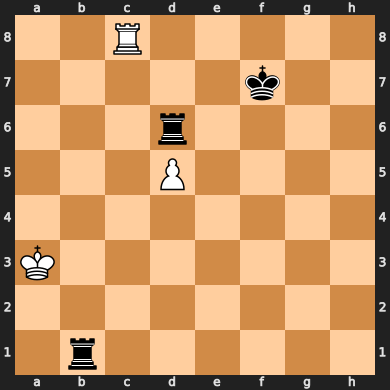

Mid Game: Random


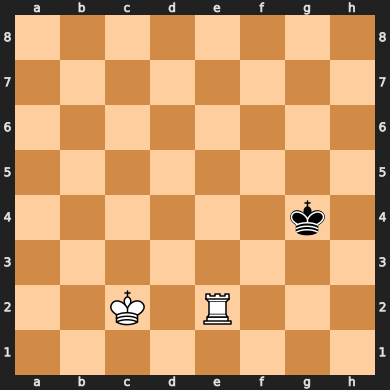

End Game: Random


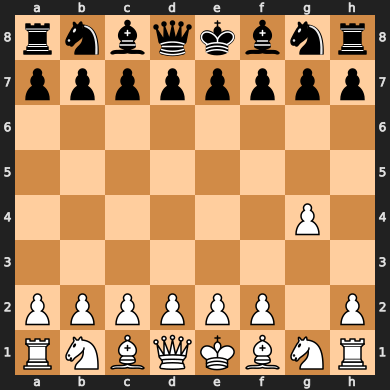

Initial Position: Greedy


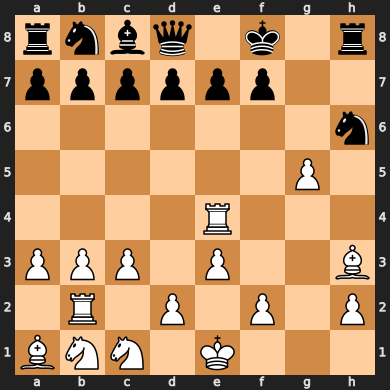

Mid Game: Greedy


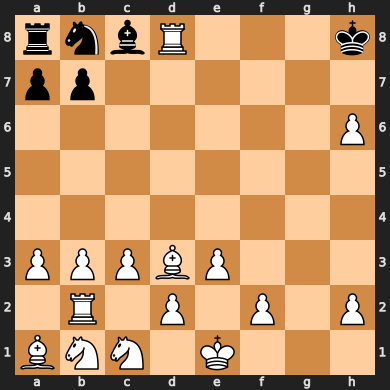

End Game: Greedy


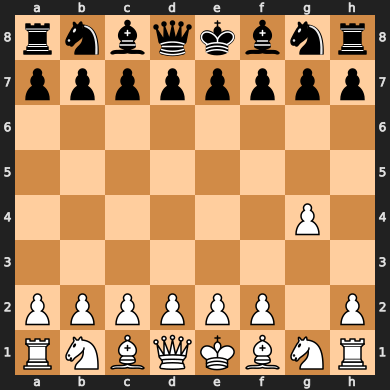

Initial Position: Development


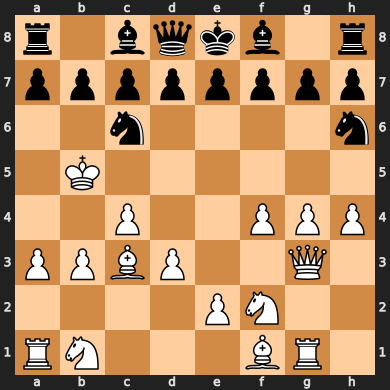

Mid Game: Development


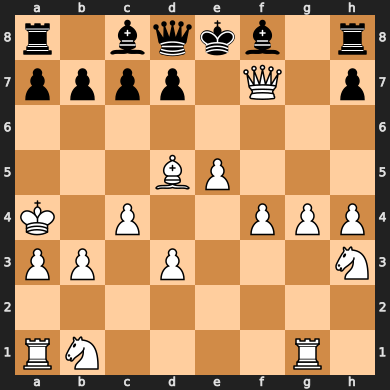

End Game: Development


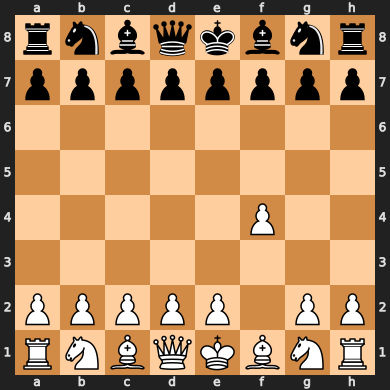

Initial Position: Castling


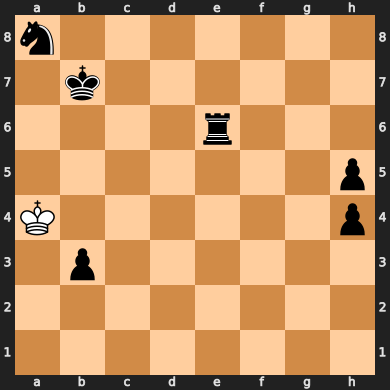

Mid Game: Castling


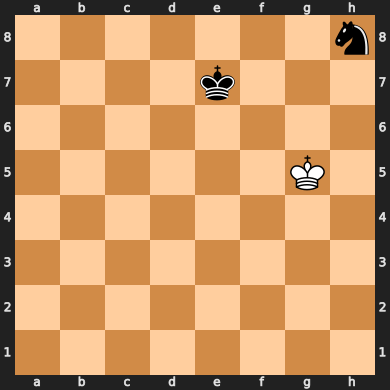

End Game: Castling


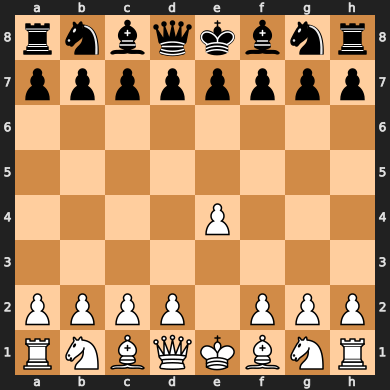

Initial Position: Pawn_structure


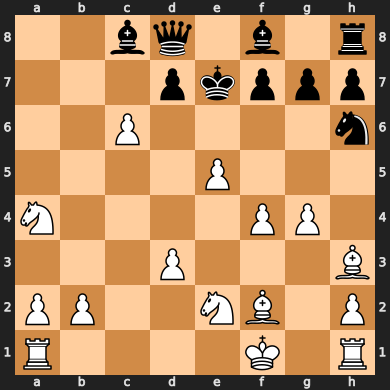

Mid Game: Pawn_structure


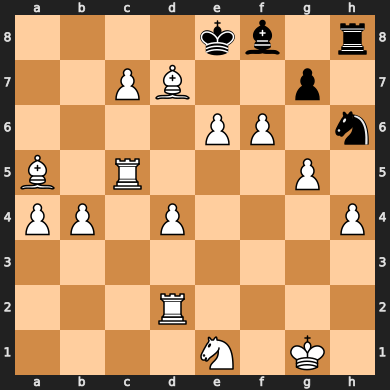

End Game: Pawn_structure
Strategy: Minimax
MCTS Wins: 7
Strategy Wins: 0
Draws: 3
Average MCTS Move Time: 0.9843 seconds
Average Strategy Move Time: 0.0918 seconds
Average MCTS Evaluation: 10.4287
Average Strategy Evaluation: 10.5839
Strategy: Random
MCTS Wins: 4
Strategy Wins: 1
Draws: 5
Average MCTS Move Time: 0.7203 seconds
Average Strategy Move Time: 0.0000 seconds
Average MCTS Evaluation: 0.1890
Average Strategy Evaluation: 0.1853
Strategy: Greedy
MCTS Wins: 9
Strategy Wins: 0
Draws: 1
Average MCTS Move Time: 0.9816 seconds
Average Strategy Move Time: 0.0007 seconds
Average MCTS Evaluation: 6.2086
Average Strategy Evaluation: 6.2906
Strategy: Development
MCTS Wins: 6
Strategy Wins: 0
Draws: 4
Average MCTS Move Time: 1.0040 seconds
Average Strategy Move Time: 0.0001 seconds
Average MCTS Evaluation: -0.8036
Average Strategy Evaluation: -0.8070
Strategy: Castling
MCTS Wins: 2
Strategy Wins: 2
Draws: 6
Average MCTS Move Time: 0.6935 seconds
Average Strategy Move Time: 0.0001 seconds
A

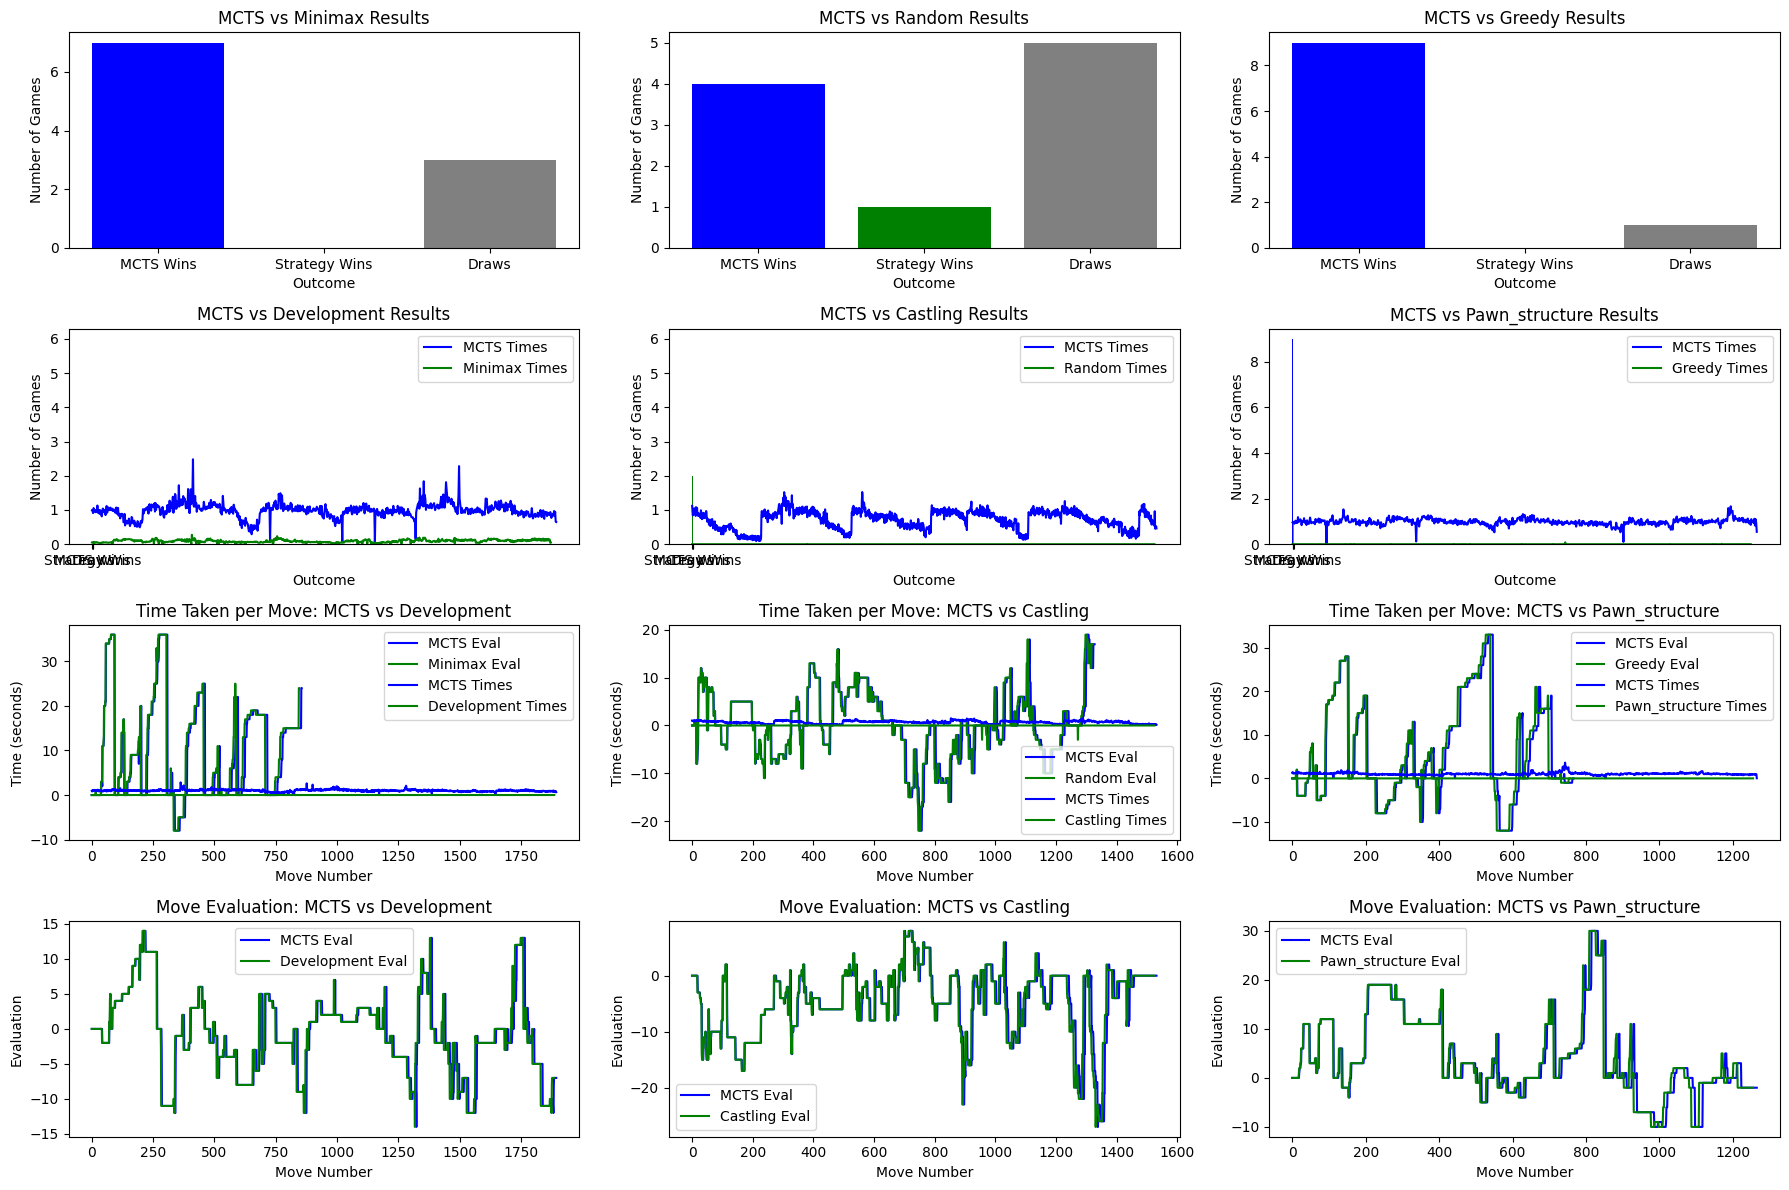

In [13]:
def main():
    num_games = 10
    mcts_iterations = 50
    minimax_depth = 2
    strategies = ['minimax', 'random', 'greedy', 'development', 'castling', 'pawn_structure']

    results = defaultdict(lambda: {'mcts_wins': 0, 'strategy_wins': 0, 'draws': 0})
    all_mcts_times = defaultdict(list)
    all_minimax_times = defaultdict(list)
    all_mcts_evals = defaultdict(list)
    all_minimax_evals = defaultdict(list)

    for strategy in strategies:
        for _ in range(num_games):
            board = chess.Board()
            if strategy in ['development', 'castling', 'pawn_structure']:
                board = endgame_scenario(board)
            result, mcts_times, minimax_times, moves, mcts_eval, minimax_eval = play_game(mcts_iterations, minimax_depth, strategy)
            all_mcts_times[strategy].extend(mcts_times)
            all_minimax_times[strategy].extend(minimax_times)
            all_mcts_evals[strategy].extend(mcts_eval)
            all_minimax_evals[strategy].extend(minimax_eval)
            
            if result == "1-0":
                results[strategy]['mcts_wins'] += 1
            elif result == "0-1":
                results[strategy]['strategy_wins'] += 1
            else:
                results[strategy]['draws'] += 1

            if _ == 0:
                visualize_board(moves[0], f'Initial Position: {strategy.capitalize()}')
                visualize_board(moves[len(moves)//2], f'Mid Game: {strategy.capitalize()}')
                visualize_board(moves[-1], f'End Game: {strategy.capitalize()}')

    for strategy in strategies:
        print(f"Strategy: {strategy.capitalize()}")
        print(f"MCTS Wins: {results[strategy]['mcts_wins']}")
        print(f"Strategy Wins: {results[strategy]['strategy_wins']}")
        print(f"Draws: {results[strategy]['draws']}")
        print(f"Average MCTS Move Time: {sum(all_mcts_times[strategy]) / len(all_mcts_times[strategy]):.4f} seconds")
        print(f"Average Strategy Move Time: {sum(all_minimax_times[strategy]) / len(all_minimax_times[strategy]):.4f} seconds")
        print(f"Average MCTS Evaluation: {sum(all_mcts_evals[strategy]) / len(all_mcts_evals[strategy]):.4f}")
        print(f"Average Strategy Evaluation: {sum(all_minimax_evals[strategy]) / len(all_minimax_evals[strategy]):.4f}")

    plt.figure(figsize=(18, 12))
    for i, strategy in enumerate(strategies, start=1):
        labels = ['MCTS Wins', 'Strategy Wins', 'Draws']
        values = [results[strategy]['mcts_wins'], results[strategy]['strategy_wins'], results[strategy]['draws']]

        plt.subplot(4, 3, i)
        plt.bar(labels, values, color=['blue', 'green', 'grey'])
        plt.xlabel('Outcome')
        plt.ylabel('Number of Games')
        plt.title(f'MCTS vs {strategy.capitalize()} Results')

        plt.subplot(4, 3, i + 3)
        plt.plot(all_mcts_times[strategy], label='MCTS Times', color='blue')
        plt.plot(all_minimax_times[strategy], label=f'{strategy.capitalize()} Times', color='green')
        plt.xlabel('Move Number')
        plt.ylabel('Time (seconds)')
        plt.title(f'Time Taken per Move: MCTS vs {strategy.capitalize()}')
        plt.legend()

        plt.subplot(4, 3, i + 6)
        plt.plot(all_mcts_evals[strategy], label='MCTS Eval', color='blue')
        plt.plot(all_minimax_evals[strategy], label=f'{strategy.capitalize()} Eval', color='green')
        plt.xlabel('Move Number')
        plt.ylabel('Evaluation')
        plt.title(f'Move Evaluation: MCTS vs {strategy.capitalize()}')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
